# Predição de ativos da bolsa de valores

# Importa as bibliotecas

In [302]:
import sys
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.offline import plot
import plotly.graph_objects as go

import datetime
from pmdarima.arima import auto_arima # biblioteca que importa o arima
import pmdarima.arima as pm # biblioteca que importa o arima
import statsmodels
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
import pandas as pd

from pandas_datareader import data 
import yfinance as yfin
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [303]:
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv1D, LSTM, MaxPooling1D, Activation, MaxPooling1D, Dropout, Flatten, BatchNormalization, GRU, AveragePooling1D, SpatialDropout1D, GlobalAveragePooling1D
#from tensorflow.keras.initializers import he_uniform
from tensorflow import keras

## Análise e visualização de ativos

### Carrega Dados

In [304]:
yfin.pdr_override()

acoes=['B3SA3','PETR4']
peso_acoes=np.ones(len(acoes))*1/len(acoes)
# adc o .SA no nome de cada ação para carregar no banco de dados
for i in range(np.size(acoes)):
    acoes[i]=acoes[i]+".SA"

acoes.append('^BVSP') # inclui o índice ibovespa na ultima coluna

acoes_df = pd.DataFrame() 
for acao in acoes:
     acoes_df[acao] = data.DataReader(acao, start='2010-01-01')['Close']

# substitui o .SA do nome de cada ação para visualização dos dados
for i in range(np.size(acoes)):
    acoes_df = acoes_df.rename(columns={acoes[i]:acoes[i].replace('.SA', '')})

#renomeia o índice IBOVESPA para IBOV   
acoes_df = acoes_df.rename(columns={acoes[i]:acoes[i].replace('^BVSP', 'IBOV')})
                           
#soma todos os valores nulos
acoes_df.isnull().sum()

#Verifica como está o shape do dataframe
acoes_df.shape
 


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


(3554, 3)

<Axes: ylabel='Date'>

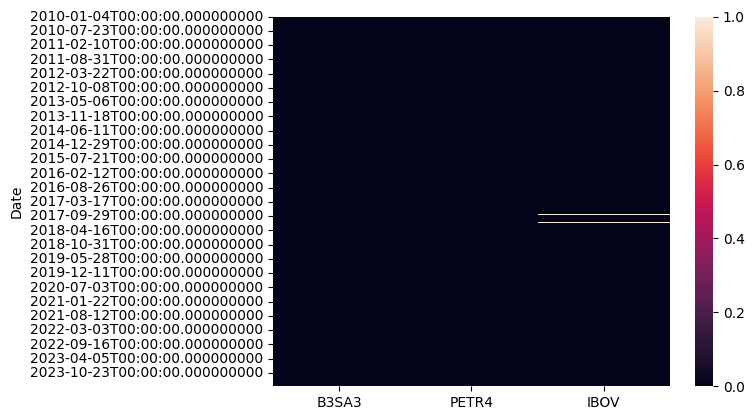

In [305]:
sns.heatmap(acoes_df.isnull())

In [306]:
#apaga registros nulos
acoes_df.dropna(inplace=True)
acoes_df.to_csv('acoes.csv')
acoes_df

,B3SA3,PETR4,IBOV
Date,,,
2010-01-04,12.95,37.320000,70045.0
2010-01-05,13.00,37.000000,70240.0
2010-01-06,13.49,37.500000,70729.0
2010-01-07,13.81,37.150002,70451.0
2010-01-08,13.49,36.950001,70263.0
...,...,...,...
2024-04-24,10.94,41.230000,124741.0
2024-04-25,10.83,42.220001,124646.0
2024-04-26,11.22,41.650002,126526.0


### Visualização dos dados 

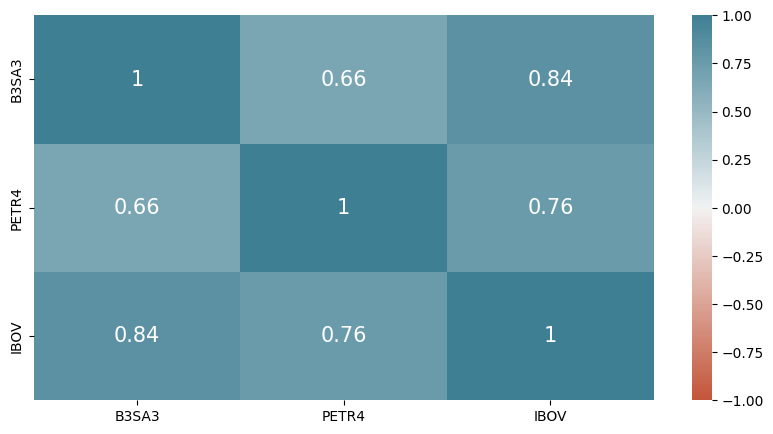

In [307]:
fig, axes = plt.subplots(1, 1, figsize=(10,5))

columns=acoes_df.columns
corrmat = acoes_df[columns].corr()
mask= np.zeros_like(corrmat)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corrmat,
            vmax=1, vmin=-1,
            annot=True, annot_kws={'fontsize':15},
            cmap=sns.diverging_palette(20,220,as_cmap=True))
plt.show()

In [308]:
# Normaliza os dados
acoes_df_normalized = acoes_df / acoes_df.iloc[0].values

In [309]:
acoes_df_normalized

,B3SA3,PETR4,IBOV
Date,,,
2010-01-04,1.000000,1.000000,1.000000
2010-01-05,1.003861,0.991426,1.002784
2010-01-06,1.041699,1.004823,1.009765
2010-01-07,1.066409,0.995445,1.005796
2010-01-08,1.041699,0.990086,1.003112
...,...,...,...
2024-04-24,0.844788,1.104770,1.780869
2024-04-25,0.836293,1.131297,1.779513
2024-04-26,0.866409,1.116024,1.806353


In [310]:
#%% Carregando dados
acoes_df=pd.read_csv('acoes.csv')
acoes_df['Date']=pd.to_datetime(acoes_df['Date'])
acoes_df=acoes_df.set_index('Date')
for col in acoes_df.columns:
    acoes_df[col]=acoes_df[col].astype('float32')

In [311]:
acoes_df_normalized = acoes_df / acoes_df.iloc[0].values

In [312]:
# Cria um gráfico de linha usando o Plotly
fig = go.Figure()
for stocks in acoes_df.columns:
#fig.add_trace(go.Scatter(x=acoes_df.index, y=acoes_df['IBOV'], mode='lines', name='Preço do Ibovespa'))
#fig.add_trace(go.Scatter(x=acoes_df.index, y=acoes_df['B3SA3'], mode='lines', name='Preço do B3SA3'))
    fig.add_trace(go.Scatter(x=acoes_df_normalized.index, y=acoes_df_normalized[stocks], mode='lines', name=f'Preço do {acoes}'))

# Configura o layout do gráfico
fig.update_layout(
    title='Preço do Ibovespa e ações',
    xaxis_title='Data',
    yaxis_title='Preço',
    showlegend=True
)

# Exibe o gráfico
fig.show()

## Indicadores de tendência e Séries Temporais 

Os swing traders geralmente utilizam médias móveis exponenciais (EMAs) de diferentes períodos para identificar tendências e sinais de compra e venda. As EMAs mais utilizadas pelos swing traders incluem:

-EMA de 9 períodos: A EMA de 9 períodos é comumente usada para identificar sinais de curto prazo e capturar movimentos rápidos do mercado. Pode fornecer sinais mais sensíveis e frequentes.

-EMA de 20 períodos: A EMA de 20 períodos é amplamente utilizada e considerada uma média móvel de curto prazo. É usada para identificar a direção da tendência de curto prazo e possíveis pontos de reversão.

-EMA de 50 períodos: A EMA de 50 períodos é frequentemente usada para identificar a direção da tendência de médio prazo. É uma média móvel amplamente observada pelos swing traders.

-EMA de 100 períodos: A EMA de 100 períodos é usada para identificar a direção da tendência de médio a longo prazo. É útil para identificar pontos de entrada e saída em operações de swing trading mais prolongadas.

-EMA de 200 períodos: A EMA de 200 períodos é uma das médias móveis mais amplamente observadas e é usada para identificar a direção da tendência de longo prazo. É frequentemente usada como um indicador-chave para determinar a tendência geral do mercado.

In [313]:
acoes_df = acoes_df.rename(columns={acoes[i]:acoes[i].replace('^BVSP', 'IBOV')})


In [314]:
import pandas as pd
import pandas_datareader as pdr
import datetime
import plotly.graph_objects as go

# Define o código de ticker da ação
ticker = "^BVSP" # ibovespa
ticker = "B3SA3"


if ticker!="^BVSP":
    ticker=ticker+".SA"

# Obtém os dados históricos da ação
df = data.DataReader(ticker, start='2015-01-01')

df.columns

[*********************100%%**********************]  1 of 1 completed


Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [315]:
df['Close'].values

array([ 3.17000008,  3.08333302,  3.11333299, ..., 11.22000027,
       11.14000034, 10.78999996])

In [316]:
scaler = MinMaxScaler()
y=scaler.fit_transform(df['Close'].values.reshape(-1,1))

# Function to compute Simple Moving Average (SMA)b
def calculate_sma(data, window):
    return data['Close'].rolling(window=window).mean()

# Function to compute Relative Strength Index (RSI)
def calculate_rsi(data, window):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Function to compute Moving Average Convergence Divergence (MACD)
def calculate_macd(data, short_window, long_window, signal_window):
    short_ema = data['Close'].ewm(span=short_window, min_periods=1, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, min_periods=1, adjust=False).mean()
    macd_line = short_ema - long_ema
    signal_line = macd_line.ewm(span=signal_window, min_periods=1, adjust=False).mean()
    return macd_line, signal_line

def calculate_bollinger_bands(data, window=20, num_std=2):
    sma = data['Close'].rolling(window=window).mean()
    std = data['Close'].rolling(window=window).std()
    upper_band = sma + num_std * std
    lower_band = sma - num_std * std
    return upper_band, lower_band

df['upper_band_bollinger'],df['lower_band_bollinger']=calculate_bollinger_bands(df)
# Calcula as EMAs de 9 e 20 períodos
df['EMA9'] = df['Close'].ewm(span=9).mean()
df['EMA20'] = df['Close'].ewm(span=20).mean()
df['EMA50'] = df['Close'].ewm(span=50).mean()
df['EMA100'] = df['Close'].ewm(span=100).mean()
df['EMA200'] = df['Close'].ewm(span=200).mean()
df['MA111*2'] = df['Close'].rolling(window=111).mean() * 2
df['MA350*2'] = df['Close'].rolling(window=350).mean() * 2


# Calculate RSI (14-period)
df['RSI_14'] = calculate_rsi(df, window=14)

# Calculate MACD (12, 26, 9)
df['MACD'], df['Signal'] = calculate_macd(df, short_window=12, long_window=26, signal_window=9)


In [317]:
# Cria um gráfico de candlestick usando o Plotly
fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'],
                name='Candlestick')])

# Adiciona as médias móveis ao gráfico
fig.add_trace(go.Scatter(x=df.index, y=df['EMA9'], mode='lines', name='EMA9'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA20'], mode='lines', name='EMA20'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA50'], mode='lines', name='EMA50'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA100'], mode='lines', name='EMA100'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA200'], mode='lines', name='EMA200'))
fig.add_trace(go.Scatter(x=df.index, y=df['MA111*2'], mode='lines', name='MA111*2'))
fig.add_trace(go.Scatter(x=df.index, y=df['MA350*2'], mode='lines', name='MA350*2'))

if ticker=="^BVSP":
    ticker='IBOV'

# Configura o layout do gráfico
fig.update_layout(
    width=1500,
    height=700,
    title=f"Gráfico de Candlestick e Médias Móveis para {ticker}",
    xaxis_title="Data",
    yaxis_title="Preço",
    showlegend=True
)

# Exibe o gráfico
fig.show()


In [318]:
# Cria um gráfico de candlestick usando o Plotly
fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'],
                name='Candlestick')])

# Adiciona as médias móveis ao gráfico
fig.add_trace(go.Scatter(x=df.index, y=df['upper_band_bollinger'], mode='lines', name='upper band bollinger'))
fig.add_trace(go.Scatter(x=df.index, y=df['lower_band_bollinger'], mode='lines', name='lower band bollinger'))


if ticker=="^BVSP":
    ticker='IBOV'

# Configura o layout do gráfico
fig.update_layout(
    width=1500,
    height=700,
    title=f"Gráfico de Candlestick e Médias Móveis para {ticker}",
    xaxis_title="Data",
    yaxis_title="Preço",
    showlegend=True
)

# Exibe o gráfico
fig.show()


In [319]:

# Calcular a variação percentual entre o preço de fechamento de um dia e o dia seguinte
df['Variation'] = ((df['Close'] - df['Close'].shift(+1)) / df['Close'])*100
#pred_data_df['Variacao'] = ((pred_data_df['pred']-pred_data_df['pred'].shift(+1)) / pred_data_df['pred'])*100


# Thresholds for variation classification
positive_threshold = 0.03
negative_threshold = -0.03

# Create a new column for classified variation
df['Classification'] = df['Variation'].apply(lambda x: 
                                            1 if x > positive_threshold else (
                                                -1 if x < negative_threshold else 0))

#df['week']=df.index.week
df['weekday']=df.index.weekday+1
df['day']=df.index.day
df['month']=df.index.month
df['quarter']=df.index.quarter

df=df.reset_index().fillna(0)
df


,Date,Open,High,Low,Close,Adj Close,Volume,upper_band_bollinger,lower_band_bollinger,EMA9,...,MA350*2,RSI_14,MACD,Signal,Variation,Classification,weekday,day,month,quarter
0,2015-01-02,3.270000,3.270000,3.150000,3.170000,2.269297,21734100,0.000000,0.000000,3.170000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0,5,2,1,1
1,2015-01-05,3.143333,3.153333,3.056666,3.083333,2.207255,34790100,0.000000,0.000000,3.121852,...,0.000000,0.000000,-0.006914,-0.001383,-2.810824,-1,1,5,1,1
2,2015-01-06,3.066666,3.113333,3.033333,3.113333,2.228730,49214700,0.000000,0.000000,3.118360,...,0.000000,0.000000,-0.009858,-0.003078,0.963597,1,2,6,1,1
3,2015-01-07,3.133333,3.283333,3.126666,3.236666,2.317021,24006600,0.000000,0.000000,3.158437,...,0.000000,0.000000,-0.002215,-0.002905,3.810494,1,3,7,1,1
4,2015-01-08,3.296666,3.300000,3.190000,3.193333,2.286000,22967700,0.000000,0.000000,3.168818,...,0.000000,0.000000,0.000343,-0.002256,-1.356985,-1,4,8,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2314,2024-04-24,11.080000,11.100000,10.890000,10.940000,10.940000,45024900,12.474290,10.826710,11.282632,...,25.559371,26.605497,-0.335580,-0.280552,-1.371120,-1,3,24,4,2
2315,2024-04-25,10.910000,10.940000,10.750000,10.830000,10.830000,32548600,12.472312,10.709688,11.192106,...,25.549543,23.999998,-0.354565,-0.295354,-1.015694,-1,4,25,4,2
2316,2024-04-26,10.970000,11.270000,10.870000,11.220000,11.220000,60635700,12.427675,10.677325,11.197685,...,25.540914,31.872515,-0.334288,-0.303141,3.475939,1,5,26,4,2
2317,2024-04-29,11.200000,11.310000,11.090000,11.140000,11.140000,43235700,12.408478,10.633522,11.186148,...,25.533657,23.175965,-0.320973,-0.306707,-0.718132,-1,1,29,4,2


## Data preprocessing to stock forecast

### Pré-processamento dos dados para predição 

In [320]:
ticker

'B3SA3.SA'

In [321]:
'''# Pré-processamento dos dados
acoes_df.reset_index(inplace=True)
#ticker='IBOV'
if 'SA' in ticker:
    ticker=ticker[:-3]
    
acoes_df = acoes_df[['Date', ticker]]
acoes_df.columns = ['ds', 'y']

# scale the data - normalization
acoes_df_norm=acoes_df.copy()
scaler = MinMaxScaler()
acoes_df_norm['y'] = scaler.fit_transform(acoes_df['y'].values.reshape(-1,1))

'''

"# Pré-processamento dos dados\nacoes_df.reset_index(inplace=True)\n#ticker='IBOV'\nif 'SA' in ticker:\n    ticker=ticker[:-3]\n    \nacoes_df = acoes_df[['Date', ticker]]\nacoes_df.columns = ['ds', 'y']\n\n# scale the data - normalization\nacoes_df_norm=acoes_df.copy()\nscaler = MinMaxScaler()\nacoes_df_norm['y'] = scaler.fit_transform(acoes_df['y'].values.reshape(-1,1))\n\n"

In [322]:
'''### Using all selected stokcs to AI database 
df=data.DataReader(acoes, start='2015-01-01')['Close']
df = pd.melt(df.reset_index(),id_vars='Date',var_name='Ação', value_name='Valor') 

df.rename(columns={'Valor': 'Close'}, inplace=True)
df'''

"### Using all selected stokcs to AI database \ndf=data.DataReader(acoes, start='2015-01-01')['Close']\ndf = pd.melt(df.reset_index(),id_vars='Date',var_name='Ação', value_name='Valor') \n\ndf.rename(columns={'Valor': 'Close'}, inplace=True)\ndf"

In [323]:
features_indicators=['EMA9', 'EMA20', 'EMA50','EMA100', 'EMA200',
                     'RSI_14', 'MACD','upper_band_bollinger', 'lower_band_bollinger']

In [324]:
# normalize the data 
df_norm=df.copy()
df_norm['Close']=scaler.transform(df['Close'].values.reshape(-1,1))

In [325]:
from tqdm import tqdm
import time
from keras.utils import Sequence
from keras import backend as K
from imblearn.over_sampling import SMOTE


class FeaturesDataGenerator(Sequence):

    def __init__(self, X_data = np.zeros([10,1]), lookback=1, pred_days=1, axis=0, batch_size=32, shuffle=False, processing=None, selected_features= None, data_augmentation=False):
        """
        Args:
            Features dataset_generator: The dataset generator providing input and output data.
            axis (int): Axis for feature computation.
            processing: Optional data processing function.
            selected_features (list): List of features to compute. If None, compute all features.
        """
        self.InputData = X_data
        self.lookback = lookback
        self.pred_days= pred_days
        self.inputShape = X_data.shape
        #self.outputShape = dataset_generator.__getitem__(0)[1].shape
        self.processing = processing
        self.axis = axis
        self.selected_features = selected_features
        self.data_augmentation = data_augmentation
        

        #self.y_classification = self.comput_outputs(self.features[:,lookback-1])
        self.y_classification = self.comput_outputs(self.InputData)
        self.features = self.comput_features(np.squeeze(self.InputData))

        if self.data_augmentation == True:
            smote = SMOTE(sampling_strategy='auto', random_state=42)
            
            self.features, self.y_classification = smote.fit_resample(self.features[:], self.y_classification[:])

            #self.InputData, self.y_classification = smote.fit_resample(self.InputData[self.lookback:].reshape(-1,1), self.y_classification)
            #self.y_classification = self.comput_outputs(self.InputData)
        
        #self.features = self.comput_features(np.squeeze(self.InputData))

        self.inputShape  = self.features.shape
        self.output_shape=self.y_classification[0].shape

        print('input data shape', self.inputShape)
        print('output data shape', self.y_classification.shape)

        self.batchSize= batch_size
        self.shuffle = shuffle

        #self.indices=np.arange(self.__len__() + self.batchSize)
        if self.batchSize>1:
            self.indices=np.arange(self.__len__() + self.batchSize)
        else:
            self.indices=np.arange(self.__len__())

        if self.shuffle == True:
            np.random.shuffle(self.indices)

    def __len__(self):

        return (np.max(self.inputShape) // self.batchSize)
    #- (len(self.selected_features)+self.lookback)
    
    def autorregressive_coefs(self,data,p=3):
        channels=data.shape(self.axis) 

        phi=np.zeros([data.shape[0],data.shape[1],p])

        ar_coefs=np.zeros([channels,p])

        y_init=[]

        y = data

        aux=np.zeros(p)
        for k in range(p): 
            aux[p-k:]=y[:k]
            y_init.append(aux.copy())

        phi=np.vstack([y[i-p:i] if i-p>=0 else y_init[i]  for i in range(0, len(y))])

        ar_coefs[:]=np.linalg.inv(phi[:].T.dot(phi[:])).dot(phi[:].T.dot(data[:]))
            
        return ar_coefs
    
    def moving_average(self,data, window_length):
        """
        Calculates the Moving Average (MA) of a time series data.

        Args:
            data: A list or NumPy array containing the time series data.
            window_length: The number of periods to use for the MA calculation (window size).

        Returns:
            A NumPy array containing the MA values for each data point.
        """

        if window_length < 1:
            raise ValueError("Window length must be a positive integer.")

        # Initialize empty array for MA values
        moving_average_values = np.zeros(len(data))

        # Iterate through the data
        for i in range(len(data)):
            # Check if the window goes beyond the data boundary
            if i < window_length - 1:
                # If within the initial window, use the average of available data points
                moving_average_values[i] = np.mean(data[:i+1])
            else:
                # For other points, use the average of the window
                window_slice = data[i - window_length + 1 : i + 1]
                moving_average_values[i] = np.mean(window_slice)

        return moving_average_values
    def exponential_moving_average(self, data, window_length):
        """
        Calculates the Exponential Moving Average (EMA) of a time series data.

        Args:
            data: A list or NumPy array containing the time series data.
            window_length: The number of periods to use for the EMA calculation.

        Returns:
            A NumPy array containing the EMA values for each data point.
        """

        if window_length < 1:
            raise ValueError("Window length must be a positive integer.")

        ema = np.zeros(len(data))
        # Handle the initial EMA calculation (use simple average for the first window_length elements)
        ema[:window_length] = np.mean(data[:window_length])
        alpha = 2 / (1 + window_length)  # Smoothing factor (weight for the current data point)

        for i in range(window_length, len(data)):
            ema[i] = alpha * data[i] + (1 - alpha) * ema[i-1]
        
        return ema
    
    def macd(self,data, fast_period=12, slow_period=26, signal_period=9):
        """
        Calculates the MACD (Moving Average Convergence Divergence) indicator for a time series data.

        Args:
            data: A list or NumPy array containing the closing price data.
            fast_period: The number of periods for the fast Exponential Moving Average (EMA). (default: 12)
            slow_period: The number of periods for the slow Exponential Moving Average (EMA). (default: 26)
            signal_period: The number of periods for the EMA of the MACD difference. (default: 9)

        Returns:
            A tuple containing three NumPy arrays:
                - macd: The MACD line (fast EMA minus slow EMA)
                - macd_signal: The signal line (EMA of the MACD difference)
                - macd_histogram: The MACD histogram (MACD minus signal line)
        """

        # Check if window lengths are positive integers
        if any(period < 1 for period in [fast_period, slow_period, signal_period]):
            raise ValueError("Window lengths must be positive integers.")

        # Calculate the fast EMA and slow EMA
        ema_fast = self.exponential_moving_average(data, fast_period)
        ema_slow = self.exponential_moving_average(data, slow_period)

        # Calculate the MACD line (fast EMA minus slow EMA)
        macd = ema_fast - ema_slow

        # Calculate the MACD signal line (EMA of the MACD difference)
        macd_signal = self.exponential_moving_average(macd, signal_period)

        # Calculate the MACD histogram (MACD minus signal line)
        macd_histogram = macd - macd_signal

        return macd, macd_signal, macd_histogram
    
    def rsi(self,data, period=14):
        """
        Calculates the Relative Strength Index (RSI) indicator for a time series data.

        Args:self.pred_days
            data: A list or NumPy array containing the closing price data.
            period: The number of periods to consider for calculating gains and losses. (default: 14)

        Returns:
            A NumPy array containing the RSI values for each data point.
        """

        if period < 1:
            raise ValueError("Period must be a positive integer.")

        # Calculate the difference between closing prices
        delta = np.diff(data)

        # Separate positive and negative changes
        up_changes = delta[delta > 0]
        down_changes = np.abs(delta[delta < 0])  # Make negative changes positive

        # Calculate the Average Gain (smoothed using EMA)
        if len(up_changes) > 0:
            avg_gain = self.exponential_moving_average(up_changes, period)
        else:
            avg_gain = np.zeros_like(down_changes)  # Handle case with no positive changes

        # Calculate the Average Loss (smoothed using EMA)
        if len(down_changes) > 0:
            avg_loss = self.exponential_moving_average(down_changes, period)
        else:
            avg_loss = np.zeros_like(up_changes)  # Handle case with no negative changes

        # Calculate the Relative Strength (RS)
        rs = np.divide(avg_gain, avg_loss, where=avg_loss != 0)  # Avoid division by zero

        # Calculate the RSI
        rsi_values = 100 - (100 / (1 + rs))

        return rsi_values
    
    def cci(self, high_prices, low_prices, close_prices, window_length=20):
        """
        Calculates the Commodity Channel Index (CCI) indicator for a time series data.

        Args:
            high_prices: A list or NumPy array containing the high prices.
            low_prices: A list or NumPy array containing the low prices.
            close_prices: A list or NumPy array containing the closing prices.
            window_length: The number of periods to use for the calculation. (default: 20)

        Returns:
            A NumPy array containing the CCI values for each data point.
        """
        typical_prices = (high_prices + low_prices + close_prices) / 3
        sma_typical_prices = self.moving_average(typical_prices, window_length=window_length)
        mean_deviation = np.mean(np.abs(typical_prices - sma_typical_prices))
        cci_values = (typical_prices - sma_typical_prices) / (0.015 * mean_deviation)
        
        return cci_values
    def stochastic(self, high_prices, low_prices, close_prices, window_length=14, smooth_k=3, smooth_d=3):
        """
        Calculates the Stochastic Oscillator indicator for a time series data.

        Args:
            high_prices: A list or NumPy array containing the high prices.
            low_prices: A list or NumPy array containing the low prices.
            close_prices: A list or NumPy array containing the closing prices.
            window_length: The number of periods to use for the calculation. (default: 14)
            smooth_k: The number of periods for smoothing %K line. (default: 3)
            smooth_d: The number of periods for smoothing %D line. (default: 3)

        Returns:
            A tuple containing two NumPy arrays:
                - percent_k: The %K line.
                - percent_d: The %D line.
        """

        if window_length < 1 or smooth_k < 1 or smooth_d < 1:
            raise ValueError("Window lengths must be positive integers.")

        # Calculate %K
        lowest_low = self.minimum(low_prices, window_length)
        highest_high = self.maximum(high_prices, window_length)
        percent_k = 100 * ((close_prices - lowest_low) / (highest_high - lowest_low))

        # Smooth %K to get %D
        percent_d = self.moving_average(percent_k, window_length=smooth_k)

        return percent_k, percent_d

    def windowing(self, data, lookback= 1):
        y_window = []
        for current_k in np.arange(lookback,len(data),1):
            
            y_window += [data[current_k-lookback:current_k]]

        y_window = np.array(y_window)
        return y_window
    
    def comput_features(self, x_data):
        """
        Args:
            emg_data (numpy.ndarray): Input EMG data.

        Returns:
            numpy.ndarray: Feature matrix computed from the input data.
        """
        
        # list with the all features. Bag of features 
        all_features = {
            'Data_lookback': self.windowing(x_data,lookback = self.lookback),
            'EMA9': self.exponential_moving_average(x_data, window_length=9)[self.lookback:], 
            'EMA20': self.exponential_moving_average(x_data, window_length=20)[self.lookback:], 
            'EMA50': self.exponential_moving_average(x_data, window_length=50)[self.lookback:], 
            'EMA100': self.exponential_moving_average(x_data, window_length=100)[self.lookback:],  
            'EMA200': self.exponential_moving_average(x_data, window_length=200)[self.lookback:], 
            'MA111': self.moving_average(x_data, window_length=111)[self.lookback:],  
            'MA350': self.moving_average(x_data, window_length=350)[self.lookback:],
            'MACD': self.macd(x_data)[0][self.lookback:],  
            'RSI_14': self.exponential_moving_average(x_data, window_length=200)[self.lookback:],
            'variations': self.diff_window_samples(x_data, days_lookback=1),
        }
   
                           
        if self.selected_features is None:
            selected_features = [key for key in all_features.keys()]
            
        else:
            selected_features = self.selected_features

        if 'Data_lookback' in selected_features:
            _selected_features = selected_features.copy()
            _selected_features.remove('Data_lookback')
            Data_lookback = np.vstack(all_features['Data_lookback'])
            if len(_selected_features) == 0:
                features = Data_lookback
                print(features.shape)
            else:
                features = np.hstack([all_features[feature][:, np.newaxis] for feature in _selected_features])
                features = np.concatenate([Data_lookback,features],axis=1)
        else:
            features = np.hstack([all_features[feature][:, np.newaxis] for feature in selected_features])

        self.features_name = selected_features

        if self.processing is not None:
            features, _ = self.processing(features, features)

        return features[:]
    
    def diff_window_samples(self, data, days_lookback):
        # Calculate percentage variations
        diff_window= ((data - np.roll(data, days_lookback)) / data) * 100
        return np.squeeze(diff_window[:-days_lookback][self.lookback-days_lookback:])
        #return np.squeeze(diff_window[:-self.lookback])

    def comput_outputs(self, close_prices, days_lookback=1, positive_threshold=2, negative_threshold=-2):
        """
        Computes variation, classifies it into buy, sell, or hold categories, and creates y_classification array.

        Args:
            close_prices (np.ndarray): NumPy array containing the closing prices.
            positive_threshold (float): Threshold for buy classification.
            negative_threshold (float): Threshold for sell classification.

        Returns:
            np.ndarray: y_classification array containing buy, sell, or hold flags.
        """
        self.variations = self.diff_window_samples(close_prices[:],days_lookback)
    
        #variations = self.variations[self.lookback-self.pred_days:-self.pred_days]
        #variations = self.variations[self.lookback-self.pred_days-2:-self.pred_days-2]
        #variations = np.roll(self.variations,-1)[self.lookback-1:-1]
        #variations = np.roll(self.variations,-1)[self.lookback-1:-1]
        '''
        # Classify variations (vectorized)
        buy_flags = np.where((self.variations > positive_threshold) & (self.variations < positive_threshold*2), 1, 0)
        sell_flags = np.where((self.variations < negative_threshold) & (self.variations > negative_threshold*2), 1, 0)

        strong_buy_flags = np.where(self.variations > positive_threshold*2, 1, 0)
        strong_sell_flags = np.where(self.variations < negative_threshold*2, 1, 0)
        hold_flags = np.where((self.variations <= positive_threshold) & (self.variations >= negative_threshold), 1, 0)
        y_classification = np.vstack([hold_flags, buy_flags, strong_buy_flags, sell_flags, strong_sell_flags]).T
        '''
        buy_flags = np.where((self.variations > positive_threshold) , 1, 0)
        sell_flags = np.where((self.variations < negative_threshold), 1, 0)
        
        hold_flags = np.where((self.variations <= positive_threshold) & (self.variations >= negative_threshold), 1, 0)
        # Combine flags into y_classification (ensure correct column order)
        y_classification = np.vstack([hold_flags, buy_flags, sell_flags]).T
         
        #y_classification=  np.append(y_classification[:-1,:],np.array([1,0,0]).reshape(1,-1),axis=0) 
        y_classification = np.append(np.roll(y_classification,-self.pred_days, axis=0)[:-self.pred_days,:],np.array([1,0,0]*self.pred_days).reshape(1,-1),axis=0) 
        '''y_classification=[]
        for var in self.variations:
            if var> positive_threshold:
                y_classification+=[1]
            elif var < negative_threshold:
                y_classification+=[2]
            elif (var <= positive_threshold) & (var >= negative_threshold) :
                y_classification+=[3]
        y_classification= np.array(y_classification).reshape(-1,1) '''
        return y_classification

    def __getFeaturesName__(self):
        return self.features_name


    def __getitem__(self, idx):

        if idx == -1:
            idx = self.__len__()
            
        batch_indices = self.indices[idx : idx + self.batchSize]
        window=len(self.selected_features)+self.lookback-1

        y = np.zeros([self.batchSize,self.output_shape[0]])
    
        features = np.zeros([self.batchSize, window])   
        for i, j in enumerate(batch_indices):
            
            #apply norm minmax for each bacth data 
            features[i,:] = self.norm_minmax(self.features[j],axis=-1,minimum=0,maximum=1)
            y[i,:] = self.y_classification[j]

        # Convertendo features e y para tensores do TensorFlow
        features = tf.convert_to_tensor(features, dtype=tf.float32)
        y = tf.convert_to_tensor(y, dtype=tf.float32)

        return features, y
    
    def bat_data(self,x_data):
        x_data= (x_data - np.min(x_data)) / (np.max(x_data) - np.min(x_data))
        return x_data
    
    def norm_minmax(self,x_data, minimum=0, maximum=1, axis=None):
        """Performs the normalization of the values in x_data

        Args:
            x_data (ndarray): 2D matrix
            y_data (any): y_data. Defaults to None.

        Returns:
            tuple[ndarray, any]: tuple with the normalized matrix in the first index
        """
        if axis == None:
            axis= self.axis
            
        samples_min = x_data.min(axis=axis,keepdims=True) + sys.float_info.epsilon
        samples_max = x_data.max(axis=axis,keepdims=True)
        x_data = (x_data - samples_min) * (maximum - minimum)
        x_data = (x_data / (samples_max - samples_min) ) + minimum
        
        return x_data

    def on_epoch_end(self):
        """Override the superclass method to shuffle the data on the end of the epoch
        """
        if self.shuffle == True:
            np.random.shuffle(self.indices)
            
    def getitem(self, index):
        """Public method to retrieve the batches during the training

        Args:
            index (int): batch indexs
        Returns:
            tuple[ndarray, ndarray]: (x[samples, ch], y[class]) data
        """
        return self.__getitem__(index)
    
    def split_data(self,X : np.array , date_time : np.datetime64,factor=0.70):
        """Split the data in train validation or test

        Args:
            X (np.array): _description_
            y (np.array): _description_
            date_time (np.datetime64): _description_
            factor (float, optional): _description_. Defaults to 0.70.

        Returns:
            _type_: _description_
        """
        nits=round(len(X)*factor)

        X_train=X[:nits]

        nit_test= np.max(X_train.shape) -1
        X_test = X[nit_test:]

        T_train = date_time[:nits]
        T_test = date_time[nit_test:]
        
        return X_train,X_test, T_train, T_test
    
    def weighted_categorical_crossentropy(self,weights):
        """
        from https://gist.github.com/wassname/ce364fddfc8a025bfab4348cf5de852d
        A weighted version of keras.objectives.categorical_crossentropy
        
        Variables:
            weights: numpy array of shape (C,) where C is the number of classes
        
        Usage:
            weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
            loss = weighted_categorical_crossentropy(weights)
            model.compile(loss=loss,optimizer='adam')
        """
        
        #weights = K.variable(weights)
        weights = tf.Variable(weights, dtype=tf.float32)    
        def loss(y_true, y_pred):
            # scale predictions so that the class probas of each sample sum to 1
            #y_true_printed = tf.print("y_true =", y_true)
            #y_pred_printed = tf.print("y_pred =", y_pred)
            
            y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
            # clip to prevent NaN's and Inf's
            y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
            # calc
            loss = y_true * K.log(y_pred) * weights
            loss = -K.sum(loss, -1)
            return loss
        
        return loss

In [326]:
# separa os dados em Treino e Teste
split_data=FeaturesDataGenerator().split_data
X_train, X_val, T_train, T_val=split_data(df['Close'].values, df['Date'], factor=0.7)
X_val, X_test, T_val, T_test=split_data(X_val.T, T_train, factor=0.7)

print('Train data shape',X_train.shape)
print('Vall data shape',X_val.shape)
print('Test data shape',X_test.shape)


input data shape (9, 11)
output data shape (9, 3)
Train data shape (1623,)
Vall data shape (488,)
Test data shape (210,)


C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_2852\776548516.py:333: RuntimeWarning:

invalid value encountered in divide



In [327]:
FeaturesDataGenerator().__getFeaturesName__()

input data shape (9, 11)
output data shape (9, 3)


C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_2852\776548516.py:333: RuntimeWarning:

invalid value encountered in divide



['Data_lookback',
 'EMA9',
 'EMA20',
 'EMA50',
 'EMA100',
 'EMA200',
 'MA111',
 'MA350',
 'MACD',
 'RSI_14',
 'variations']

In [328]:
#features_indicators=FeaturesDataGenerator().features_name
#features_indicators=['Data_lookback','variations','EMA9', 'EMA20', 'EMA50', 'EMA100', 'EMA200']
features_indicators=['Data_lookback','variations','EMA9', 'EMA20', 'EMA50', 'EMA100', 'EMA200','MA111', 'MA350','MACD','RSI_14']
#features_indicators=['Data_lookback','variations']
pred_days = 1
lookback = 23
batch_size = 16
shuffle = True
X_data_gen_train = FeaturesDataGenerator(X_train, lookback = lookback, pred_days = pred_days, shuffle= shuffle, batch_size=batch_size, selected_features = features_indicators, data_augmentation=True)
X_data_gen_val = FeaturesDataGenerator(X_val, lookback = lookback, pred_days = pred_days, shuffle= shuffle, batch_size=batch_size, selected_features = features_indicators, data_augmentation=False)
X_data_gen_test = FeaturesDataGenerator(X_test, lookback = lookback, pred_days = pred_days, shuffle= shuffle, batch_size=batch_size, selected_features = features_indicators, data_augmentation=False)

input data shape (3285, 33)
output data shape (3285, 3)
input data shape (465, 33)
output data shape (465, 3)
input data shape (187, 33)
output data shape (187, 3)


In [329]:
X_data_gen_train.variations.reshape(-1,1).shape

(1600, 1)

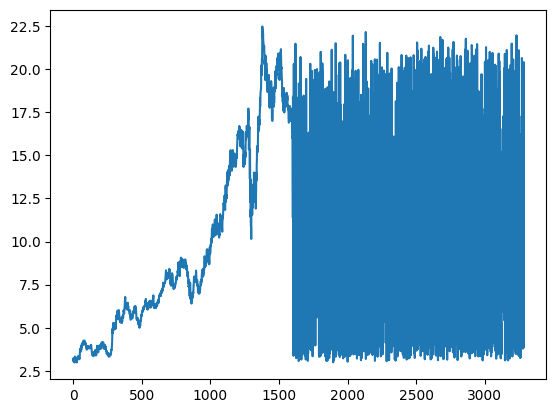

In [330]:
plt.plot(X_data_gen_train.features[:,0])
plt.show()

In [331]:
X_data_gen_train.variations.reshape(-1,1)

array([[ 2.71399271],
       [ 1.74360275],
       [-0.72316213],
       ...,
       [ 3.35128364],
       [ 1.41593904],
       [ 0.99299105]])

In [332]:
X_data_gen_train.y_classification.shape
X_data_gen_train.features[:,0].shape

(3285,)

In [333]:
aux_data=np.hstack([X_data_gen_test.variations.reshape(-1,1),X_data_gen_test.features[:,0].reshape(-1,1),X_data_gen_test.y_classification])
#recomentations_2=pd.DataFrame(data=aux_data,columns=['var','X', 'Hold','Buy','Strong_Buy','Sell','Strong_Sell'])
recomentations_2=pd.DataFrame(data=aux_data,columns=['var','X', 'Hold','Buy','Sell'])
recomentations_2.head(20)    


,var,X,Hold,Buy,Sell
0,0.815217,13.95,1.0,0.0,0.0
1,1.208049,14.64,1.0,0.0,0.0
2,-1.085481,14.61,1.0,0.0,0.0
3,0.203119,14.93,1.0,0.0,0.0
4,0.672491,14.74,1.0,0.0,0.0
5,-1.087694,14.73,1.0,0.0,0.0
6,-0.546821,14.18,1.0,0.0,0.0
7,-0.966186,14.36,1.0,0.0,0.0
8,-1.328668,14.08,1.0,0.0,0.0
9,-0.210229,13.93,1.0,0.0,0.0


In [334]:
#recomentations_2=pd.DataFrame(data=np.hstack([np.roll(X_data_gen_train.variations.reshape(-1,1),1)[lookback:],X_data_gen_train.features[:,lookback-1].reshape(-1,1),X_data_gen_train.y_classification]),columns=['var','X', 'Hold','Buy','Sell'])
#recomentations_2.head(10)

In [335]:
'''variations = ((X_train - np.roll(X_train, 1)) / X_train) * 100
recomendations=pd.DataFrame(data=np.hstack([np.vstack([variations[lookback:-pred_days],X_train[lookback:-pred_days]]).T,X_data_gen_train.comput_outputs(X_train)]), columns=['var','X', 'Hold','Buy','Sell'])
recomendations.head(10)'''

"variations = ((X_train - np.roll(X_train, 1)) / X_train) * 100\nrecomendations=pd.DataFrame(data=np.hstack([np.vstack([variations[lookback:-pred_days],X_train[lookback:-pred_days]]).T,X_data_gen_train.comput_outputs(X_train)]), columns=['var','X', 'Hold','Buy','Sell'])\nrecomendations.head(10)"

###  Get imbalanced database 

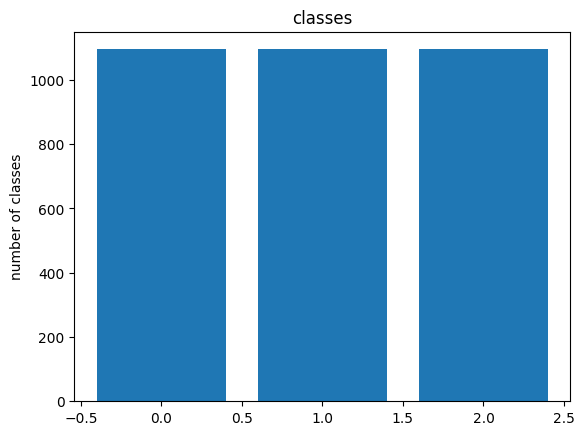

In [336]:
Y_train_categorical=np.argmax(X_data_gen_train.y_classification,axis=1)
classes, counts=np.unique(Y_train_categorical,return_counts=True) 

fig, ax = plt.subplots()
plt.bar(classes,counts)
ax.set_ylabel('number of classes')
ax.set_title('classes')
plt.show()

In [337]:
n_classes=X_data_gen_train.y_classification.shape[1]

In [338]:
from sklearn.utils import class_weight
output_class_weights = class_weight.compute_class_weight('balanced', classes=np.arange(n_classes), y=np.argmax(X_data_gen_train.y_classification,axis=1))
print(output_class_weights)
weighted_categorical_crossentropy_loss= X_data_gen_train.weighted_categorical_crossentropy(output_class_weights)

[1. 1. 1.]


## Neural Networkt aproach

In [339]:
X_data,y_data=X_data_gen_train[0]
n_classes=y_data.shape[1]
n_classes

3

### Used Models

#### CNN_LSTM

In [340]:
# Model name
model_name = "CNN_LSTM_MultiHead"
#np.random.seed(42)

# Define CNN-LSTM feature extraction function
def CNN_LSTM(inputs):
  x = Conv1D(64, kernel_size=1, strides=1, activation='relu')(inputs)
  x = BatchNormalization()(x)
  x = MaxPooling1D(2)(x)
  x = Dropout(0.2)(x)
  return x

def CNN_bracnh(Features):
    x = Conv1D(64, kernel_size=1, strides=1, activation='relu')(Features)
    x = BatchNormalization()(x)
    x = MaxPooling1D(1)(x)
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    return x
  
# Define a single function for both heads (regression and classification)
def head(features, n_outputs, activation, name= None):
  x = Dense(256)(features)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  output = Dense(n_outputs)(x)

  output = Activation(activation, name=name)(output)  # Dynamic output name

  return output

# Create the full model
input_shape = (X_data.shape[1], 1)  # Assuming your input shape
input_data = Input(shape=input_shape)

Features = CNN_LSTM(input_data)
#features_branch1=CNN_bracnh(Features)
features_branch2=CNN_bracnh(Features)
# Create separate heads with appropriate number of outputs and activations
#regression_output = head(features_branch1, n_outputs=pred_days, activation='linear',name='regression_head')
classification_output = head(features_branch2, n_outputs=n_classes, activation='softmax',name='classification_head')

# Create the model with two heads
model_CNN_LSTM = Model(inputs=input_data, outputs=[classification_output])
model_CNN_LSTM._name = model_name

# Print model summary
model_CNN_LSTM.summary()

Model: "functional_63"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_33 (InputLayer)     │ (None, 33, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_20 (Conv1D)              │ (None, 33, 64)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 33, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_20 (MaxPooling1D) │ (None, 16, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 16, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_21 (Conv1D)              │ (None, 16, 64)         │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_50          │ (None, 16, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_21 (MaxPooling1D) │ (None, 16, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 16, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_51          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_53 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 3)              │           771 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_head             │ (None, 3)              │             0 │
│ (Activation)                    │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 268,995 (1.03 MB)

 Trainable params: 268,227 (1.02 MB)

 Non-trainable params: 768 (3.00 KB)

In [341]:
X_data.shape

TensorShape([16, 33])

In [342]:
# Model name
model_name = "CNN_MultiHead"
#np.random.seed(42)

def common_layers(input1):
        """Common layers to the network model

        Returns:
            Graph: the common layers model
        """

        ##################################################################
        # CNN architecture
        conv_layer = Conv1D(64, (3), padding="same")(input1)
        conv_layer = BatchNormalization()(conv_layer)
        conv_layer = Activation('relu')(conv_layer)
        conv_layer = MaxPooling1D(pool_size=(3), strides=1, padding="same")(conv_layer)
        conv_layer = Conv1D(128, (3), padding="same")(conv_layer)
        conv_layer = BatchNormalization()(conv_layer)
        conv_layer = Activation('relu')(conv_layer)
        conv_layer = MaxPooling1D(pool_size=(3), strides=2, padding="same")(conv_layer)
        
        ##################################################################

        return conv_layer

def head_layer(conv_layer, num_classes, activation='linear', output_name=None):
    
    head1 = Conv1D(64, (3), padding="same")(conv_layer)
    head1 = BatchNormalization()(head1)
    head1 = Activation('relu')(head1)
    head1 = MaxPooling1D(pool_size=(3), strides=2, padding="same")(head1)

    head1 = Dropout(0.2)(head1)
    head1 = Flatten()(head1)

    x = Dense(256)(head1)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)

    x = Dense(128)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)

    x = Dense(num_classes)(x)
    x = Activation(activation, name=output_name)(x)

    return x

# Create the full model
input_data = Input(shape=input_shape)

Features = common_layers(input_data)
# Create separate heads with appropriate number of outputs and activations
#regression_output = head_layer(Features, num_classes=pred_days, activation='linear',output_name='regression_head')
classification_output = head_layer(Features, num_classes=n_classes, activation='softmax',output_name='classification_head')

# Create the model with two heads
model_CNN_MultiHead = Model(inputs=input_data, outputs=[classification_output])
model_CNN_MultiHead._name = model_name

# Print model summary
model_CNN_MultiHead.summary()

Model: "functional_65"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_34 (InputLayer)     │ (None, 33, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_22 (Conv1D)              │ (None, 33, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_52          │ (None, 33, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_54 (Activation)      │ (None, 33, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_22 (MaxPooling1D) │ (None, 33, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_23 (Conv1D)              │ (None, 33, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_53          │ (None, 33, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_55 (Activation)      │ (None, 33, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_23 (MaxPooling1D) │ (None, 17, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_24 (Conv1D)              │ (None, 17, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_54          │ (None, 17, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_56 (Activation)      │ (None, 17, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_24 (MaxPooling1D) │ (None, 9, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 9, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 256)            │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_55          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_57 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_56          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_58 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 233,155 (910.76 KB)

 Trainable params: 231,875 (905.76 KB)

 Non-trainable params: 1,280 (5.00 KB)

#### MultiLayer Perceptron

In [343]:
# Model name
model_name = "MLP"

# Input layer
input_shape = (X_data.shape[1],)  # Assuming your input shape
input_data = Input(shape=input_shape)

# Dense layer 1 with batch normalization
x = Dense(64)(input_data)
#x = BatchNormalization()(x)
activation1 = Activation('relu')(x)

#Dense layer 2 with batch normalization and dropout
x = Dense(32)(activation1)
#x = BatchNormalization()(x)
activation2 = Activation('relu')(x)
x = Dropout(0.2)(activation2)


# Define a single function for both heads (regression and classification)
def head(features, n_outputs, activation='linear', name= None):
  """
  Defines a dense layer head for either regression or classification.

  Args:
      features: Input tensor from the feature extraction part.
      n_outputs: Number of outputs for the head.
      activation: Activation function for the output layer (defaults to 'linear' for regression).

  Returns:
      A Keras functional API model representing the head with its output.
  """

  x = Dense(32)(features)
  #x = BatchNormalization()(x)
  x = Activation('relu')(x)
  
  output = Dense(n_outputs)(x)
  output = Activation(activation, name=name)(output)  # Dynamic output name

  return output


# Create separate heads with appropriate number of outputs and activations
#regression_output = head(activation2, n_outputs=pred_days, activation='linear',name='regression_head')
classification_output = head(activation2, n_outputs=n_classes, activation='softmax',name='classification_head')

# Create the model
model_MLP = Model(inputs=input_data, outputs=[classification_output])
model_MLP._name = model_name

# Print model summary
model_MLP.summary()


Model: "functional_67"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_35 (InputLayer)     │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 64)             │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_59 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_60 (Activation)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_61 (Activation)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 3)              │            99 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_head             │ (None, 3)              │             0 │
│ (Activation)                    │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,411 (21.14 KB)

 Trainable params: 5,411 (21.14 KB)

 Non-trainable params: 0 (0.00 B)

In [344]:
model_name = "simple_MLP"
model_simple_MLP = Sequential([
    Dense(64, activation='relu', input_shape=(X_data.shape[1],)),
    Dense(32, activation='relu'),
    Dense(n_classes, activation='softmax')
])

model_simple_MLP._name = model_name
model_simple_MLP.summary()

d:\Projetos_python\Time_Series_Forecast\.venv\lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_98 (Dense)                │ (None, 64)             │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,355 (17.01 KB)

 Trainable params: 4,355 (17.01 KB)

 Non-trainable params: 0 (0.00 B)

#### Long Short-Term Memory (LSTM) 

In [345]:
model_name= "LSTM"
# Camada de entrada
input_shape = (X_data.shape[1],1)  # Assuming your input shape
input_data = Input(shape=input_shape)

# Camada LSTM
lstm_output  = LSTM(64, return_sequences=False)(input_data)
bn_lstm = BatchNormalization()(lstm_output)
activation_lstm = Activation('relu')(bn_lstm)
Dropout_output = Dropout(0.2)(activation_lstm)

#lstm_output2  = LSTM(64, activation='relu', return_sequences=True)(Dropout_output)
#Dropout_output = Dropout(0.1)(lstm_output2)

#lstm_output3  = LSTM(64, activation='relu', return_sequences=True)(Dropout_output)
#Dropout_output = Dropout(0.1)(lstm_output3)

#lstm_output  = LSTM(4, activation='tanh')(Dropout_output)
#Dropout_output = Dropout(0.2)(lstm_output)

#dense_output = Dense(32, activation='relu')(Dropout_output)
#Dropout_output=Dropout(0.2)(dense_output)

#dense_output = Dense(8, activation='relu')(Dropout_output)
#Dropout_output=Dropout(0.2)(dense_output)
# Camada de saída
output = Dense(n_classes, activation='softmax')(Dropout_output)

model_LSTM = Model(inputs=input_data, outputs=output)
model_LSTM._name = model_name
model_LSTM.summary()

Model: "functional_70"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_37 (InputLayer)     │ (None, 33, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_57          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_62 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,347 (67.76 KB)

 Trainable params: 17,219 (67.26 KB)

 Non-trainable params: 128 (512.00 B)

#### Long Short-Term Memory (GRU) 

In [346]:
model_name= "GRU"
# Camada de entrada
input_shape = (X_data.shape[1],1)  # Assuming your input shape
input_data = Input(shape=input_shape)
# Camada LSTM
GRU_output  = GRU(64)(input_data)

bn_lstm = BatchNormalization()(GRU_output)
activation_lstm = Activation('relu')(bn_lstm)
Dropout_output = Dropout(0.2)(activation_lstm)

output = Dense(n_classes, activation='softmax')(Dropout_output)

model_GRU = Model(inputs=input_data, outputs=output)
model_GRU._name = model_name
model_GRU.summary()

Model: "functional_72"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_38 (InputLayer)     │ (None, 33, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 64)             │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_58          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_63 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_102 (Dense)               │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,315 (52.01 KB)

 Trainable params: 13,187 (51.51 KB)

 Non-trainable params: 128 (512.00 B)

#### LSTM with Attention layer

In [347]:
@tf.keras.utils.register_keras_serializable(package="Attention")
class Attention(tf.keras.layers.Layer):
    def __init__(self, units,  **kwargs):
        super(Attention, self).__init__( **kwargs)
        self.units = units
        self.W = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def build(self, input_shape):
        self.W.build(input_shape)
        self.V.build(input_shape)

    def call(self, inputs):
        # Compute attention scores
        score = tf.nn.tanh(self.W(inputs))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # Apply attention weights to input
        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector

    @classmethod
    def from_config(cls, config):
        return cls(**config)


In [348]:
model_name= "LSTM_AT"
# Camada de entrada
input_shape = (X_data.shape[1],1)  # Assuming your input shape
input_data = Input(shape=input_shape)

LSTM_output = tf.keras.layers.LSTM(64, return_sequences=True)(input_data)

bn_lstm = BatchNormalization()(LSTM_output)
activation_lstm = Activation('relu')(bn_lstm)
X = Dropout(0.2)(activation_lstm)

x = Attention(64)(X)
x = tf.keras.layers.Dense(n_classes,activation='softmax')(x)

model_LSTM_AT = tf.keras.Model(inputs=input_data, outputs=x)
model_LSTM_AT._name = model_name

model_LSTM_AT.summary()

Model: "functional_74"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_39 (InputLayer)     │ (None, 33, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 33, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_59          │ (None, 33, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_64 (Activation)      │ (None, 33, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 33, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_9 (Attention)         │ (None, 64)             │         4,225 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_105 (Dense)               │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,572 (84.27 KB)

 Trainable params: 21,444 (83.77 KB)

 Non-trainable params: 128 (512.00 B)

### Hyperparams and trainnig

**Metrics and Loss Functions**  

In [349]:
from tensorflow.keras import backend as K

def matthews_correlation_coefficient(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))

    num = tp * tn - fp * fn
    den = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    return num / K.sqrt(den + K.epsilon())

def R2(y_true, y_pred): # squareds Pearson's correlation coef 
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot - K.epsilon()) )

def NRMSE(y_true, y_pred): # normalized_root_mean_squared_error
    return 1-K.sqrt(K.mean(K.square(y_pred - y_true))) 

MSE= tf.keras.losses.mean_squared_error
MAE = tf.keras.losses.mean_absolute_error
MAPE = tf.keras.losses.mean_absolute_percentage_error

**Optimizers**  

In [350]:
def get_optimizer():
    optimizer1 = tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=True, name="Adam")
    #optimizer1 = tf.keras.optimizers.RMSprop(learning_rate=0.05)
    return optimizer1
    #

**Train options callbacks**  

In [351]:
# Avalia se está tendo avanção de desempenho no treinamento/validação e para caso não tenha avanço 
EarlyStopping=tf.keras.callbacks.EarlyStopping( monitor="val_loss", patience=20, verbose=1, mode="min", restore_best_weights=True,)

# verifica se está tendo avanço de desempenho durante o treinamento, caso não reduz integralmente o lr
reduceLr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor = 0.2, patience = 5, min_lr=1e-10,verbose=1)


checkpoint_filepath = './models_checkpoint/'
checkpoint_filepath =f'models/{model_name}_{ticker}_{lookback}_ex1'


def checkpoints(model_name):
    checkpoint_filepath =f'models/model_{model_name}_stock_{ticker}_lookback_{lookback}.keras'
    csvLogger = tf.keras.callbacks.CSVLogger(checkpoint_filepath+'_history.csv', separator=',',append=True)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, verbose=1, save_weights_only=False, monitor='val_loss', mode='min', save_best_only=True)
    print("Training model :", checkpoint_filepath)

    return csvLogger, model_checkpoint_callback

### Models train

In [352]:
#ategorical_accuracy =tf.keras.metrics.categorical_accuracy
#loss =tf.keras.losses.categorical_crossentropy
loss = weighted_categorical_crossentropy_loss
#loss = tf.keras.losses.MAE


Training model : models/model_MLP_stock_B3SA3.SA_lookback_23.keras
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Initing train fo model: MLP
Epoch 1/200


d:\Projetos_python\Time_Series_Forecast\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.




Epoch 1: val_loss improved from inf to 1.19579, saving model to models/model_MLP_stock_B3SA3.SA_lookback_23.keras
205/205 - 12s - 60ms/step - accuracy: 0.6899 - loss: 0.8442 - matthews_correlation_coefficient: 0.5343 - val_accuracy: 0.4634 - val_loss: 1.1958 - val_matthews_correlation_coefficient: 0.1950 - learning_rate: 0.0100
Epoch 2/200

Epoch 2: val_loss improved from 1.19579 to 1.17016, saving model to models/model_MLP_stock_B3SA3.SA_lookback_23.keras
205/205 - 2s - 11ms/step - accuracy: 0.6805 - loss: 0.8488 - matthews_correlation_coefficient: 0.5207 - val_accuracy: 0.4871 - val_loss: 1.1702 - val_matthews_correlation_coefficient: 0.2306 - learning_rate: 0.0100
Epoch 3/200

Epoch 3: val_loss improved from 1.17016 to 1.10597, saving model to models/model_MLP_stock_B3SA3.SA_lookback_23.keras
205/205 - 2s - 11ms/step - accuracy: 0.6848 - loss: 0.8459 - matthews_correlation_coefficient: 0.5271 - val_accuracy: 0.5043 - val_loss: 1.1060 - val_matthews_correlation_coefficient: 0.2565 -

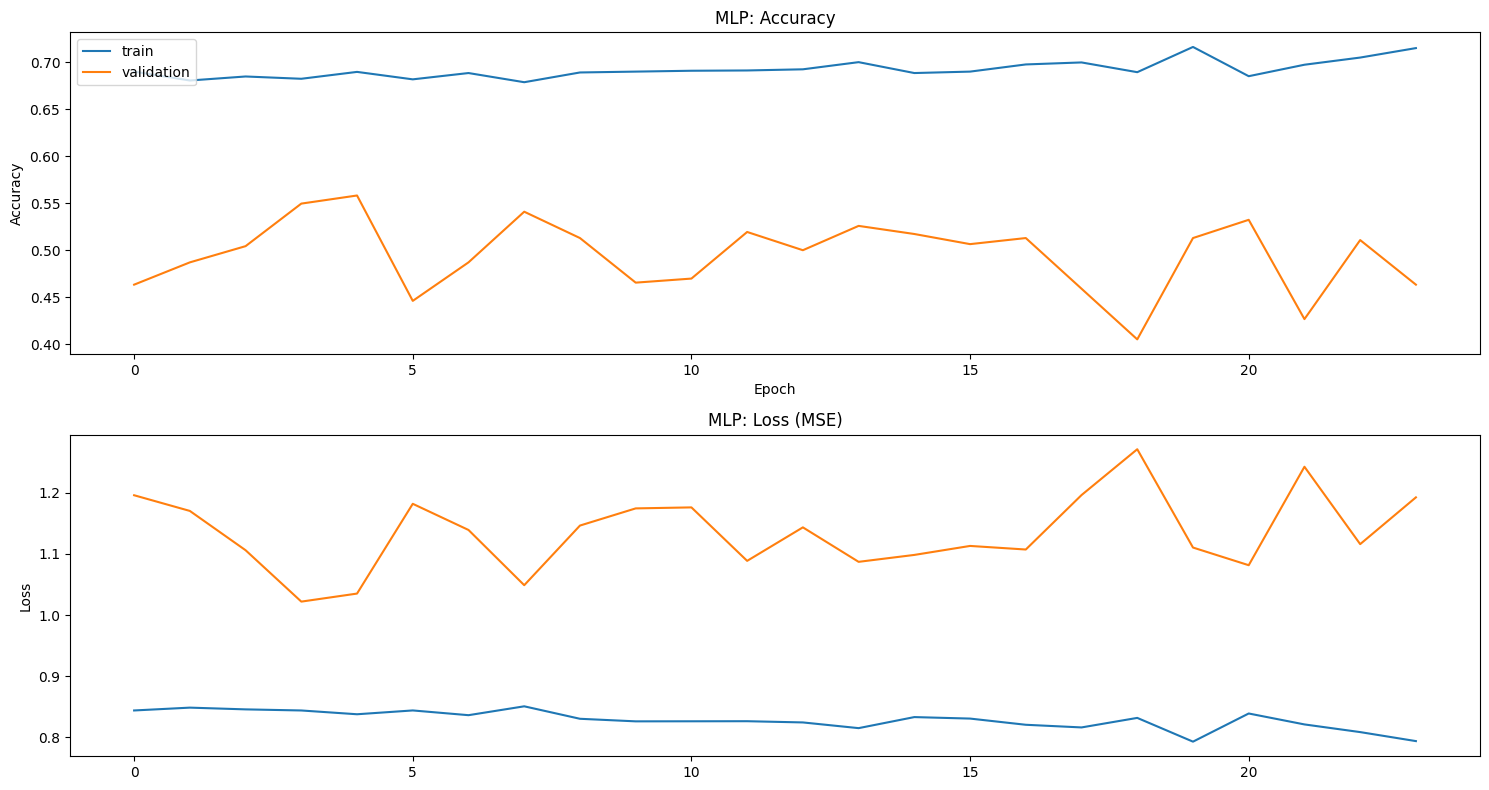

Training model : models/model_CNN_LSTM_MultiHead_stock_B3SA3.SA_lookback_23.keras
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Initing train fo model: CNN_LSTM_MultiHead
Epoch 1/200



Epoch 1: val_loss improved from inf to 1.07558, saving model to models/model_CNN_LSTM_MultiHead_stock_B3SA3.SA_lookback_23.keras
205/205 - 19s - 95ms/step - accuracy: 0.6851 - loss: 0.8322 - matthews_correlation_coefficient: 0.5248 - val_accuracy: 0.5000 - val_loss: 1.0756 - val_matthews_correlation_coefficient: 0.2500 - learning_rate: 0.0100
Epoch 2/200

Epoch 2: val_loss did not improve from 1.07558
205/205 - 5s - 23ms/step - accuracy: 0.7518 - loss: 0.6282 - matthews_correlation_coefficient: 0.6241 - val_accuracy: 0.3987 - val_loss: 1.5055 - val_matthews_correlation_coefficient: 0.0575 - learning_rate: 0.0100
Epoch 3/200

Epoch 3: val_loss did not improve from 1.07558
205/205 - 5s - 26ms/step - accuracy: 0.7832 - loss: 0.5467 - matthews_correlation_coefficient: 0.6752 - val_accuracy: 0.5259 - val_loss: 2.0736 - val_matthews_correlation_coefficient: 0.2811 - learning_rate: 0.0100
Epoch 4/200

Epoch 4: val_loss did not improve from 1.07558
205/205 - 4s - 22ms/step - accuracy: 0.7933 

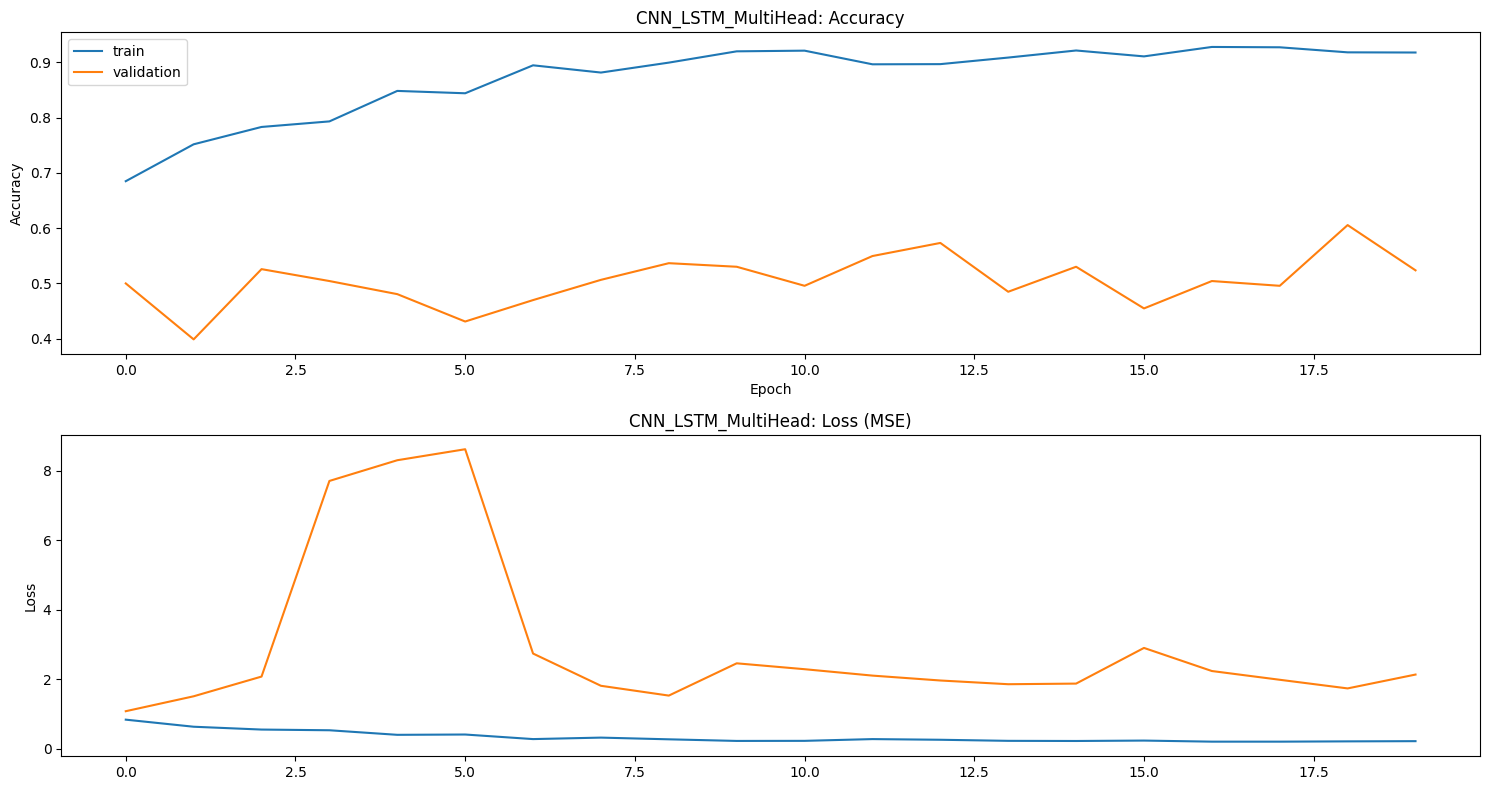

Training model : models/model_LSTM_AT_stock_B3SA3.SA_lookback_23.keras
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Initing train fo model: LSTM_AT
Epoch 1/200

Epoch 1: val_loss improved from inf to 1.23653, saving model to models/model_LSTM_AT_stock_B3SA3.SA_lookback_23.keras
205/205 - 16s - 76ms/step - accuracy: 0.6857 - loss: 0.8461 - matthews_correlation_coefficient: 0.5259 - val_accuracy: 0.3944 - val_loss: 1.2365 - val_matthews_correlation_coefficient: 0.0916 - learning_rate: 0.0100
Epoch 2/200

Epoch 2: val_loss did not improve from 1.23653
205/205 - 6s - 28ms/step - accuracy: 0.6884 - loss: 0.8285 - matthews_correlation_coefficient: 0.5293 - val_accuracy: 0.5496 - val_loss: 1.8253 - val_matthews_correlation_coefficient: 0.3244 - learning_rate: 0.0100
Epoch 3/200

Epoch 3: val_loss improved from 1.23653 to 1.17287, saving model to models/model_LSTM_AT_stoc

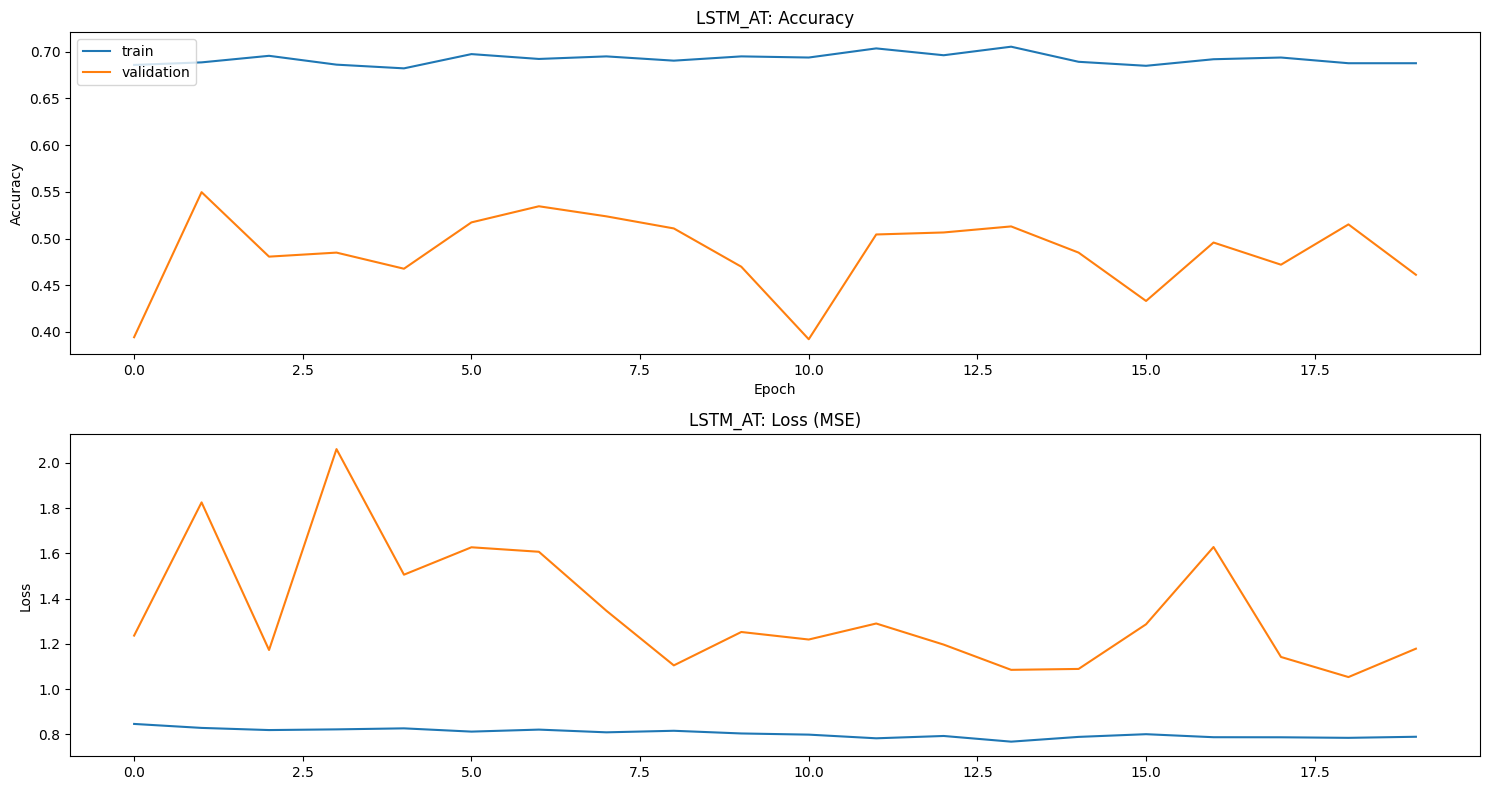

In [353]:
list_of_models=[model_MLP, model_GRU, model_CNN_LSTM, model_LSTM, model_LSTM_AT]
#list_of_models=[model_LSTM, model_LSTM_AT, model_GRU ]
#list_of_models=[model_LSTM_AT]
list_of_models=[model_MLP, model_CNN_LSTM, model_LSTM_AT]

for model in list_of_models:  
    optimizer = get_optimizer()
    csvLogger, model_checkpoint_callback  = checkpoints(model._name)
    model.compile(loss=[loss], optimizer=optimizer, metrics=['accuracy',matthews_correlation_coefficient])

    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print(f'Initing train fo model: {model._name}')
    #history=model.fit( X_data_gen_train, validation_data=X_data_gen_val, epochs=200, batch_size=32, shuffle=False, validation_split=0.3, callbacks=[EarlyStopping, reduceLr, model_checkpoint_callback,csvLogger])
    #history=model.fit_generator( X_data_gen_train, epochs=200, callbacks=[EarlyStopping, reduceLr, model_checkpoint_callback,csvLogger], validation_data=X_data_gen_val, verbose=0)
    #history=model.fit( X_data_gen_train.features, X_data_gen_train.y_classification, epochs=200, verbose=1)
    history = model.fit(
        X_data_gen_train,
        epochs=200,
        callbacks=[EarlyStopping, reduceLr, model_checkpoint_callback, csvLogger],
        validation_data=X_data_gen_val,
        #shuffle=True,
        verbose=2
    )
    # Assuming history_metric, history_metric_val, history are defined elsewhere

    fig, axes = plt.subplots(2, 1, figsize=(15, 8))  # Create subplots programmatically

    # Plot accuracy, sharing x-axis with NRMSE
    axes[0].plot(history.history['accuracy'])
    axes[0].plot(history.history['val_accuracy'])
    axes[0].set_title(f'{model._name}: Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')  # Shared x-axis label
    axes[0].legend(['train', 'validation'], loc='upper left')

    # Plot loss
    axes[1].plot(history.history['loss'])
    axes[1].plot(history.history['val_loss'])
    axes[1].set_title(f'{model._name}: Loss (MSE)')
    axes[1].set_ylabel('Loss')

    # Adjust spacing and margins (optional)
    plt.subplots_adjust(left=0.1, bottom=0.15, right=0.9, top=0.9, wspace=0.2)

    # Fine-tune spacing (optional)
    plt.tight_layout()

    plt.show()

    #history=model.fit( x=X_train, y=y_train, epochs=200, batch_size=256, shuffle=True, validation_split=0.1, callbacks=[EarlyStopping,model_checkpoint_callback, reduceLr])

### Validation

In [368]:
# carrega os modelos terinados
trained_best_models={}
for model in list_of_models:
    checkpoint_filepath =f'models/model_{model._name}_stock_{ticker}_lookback_{lookback}.keras'
    trained_best_models[f'{model._name}']=tf.keras.models.load_model(
        checkpoint_filepath, 
        custom_objects={'loss': weighted_categorical_crossentropy_loss, 'matthews_correlation_coefficient': matthews_correlation_coefficient})

In [369]:
X_data_gen_test = FeaturesDataGenerator(X_test, lookback = lookback, pred_days = pred_days, shuffle= shuffle, batch_size=1, selected_features = features_indicators)

test_data=[]
targets=[]
for X,y in X_data_gen_test:
    #train_data+=[scaler.transform(np.array(X).reshape(-1,1))]
    test_data+=[np.array(X)]
    targets+=[np.argmax(y)]
targets = np.stack(targets)
test_data = np.vstack(test_data)

input data shape (187, 33)
output data shape (187, 3)


In [370]:
'''data_real_gen_train = FeaturesDataGenerator(df['Close'].values, lookback = lookback, pred_days = pred_days, shuffle= True, batch_size=1, selected_features = features_indicators)
comput_features= data_real_gen_train.comput_features
comput_outputs=data_real_gen_train.comput_outputs

train_data=[]
targets=[]
for X,y in data_real_gen_train:
    train_data+=[scaler.transform(np.array(X).reshape(-1,1))]
    targets+=[np.argmax(y)]
targets = np.stack(targets)
train_data = np.hstack(train_data)'''

"data_real_gen_train = FeaturesDataGenerator(df['Close'].values, lookback = lookback, pred_days = pred_days, shuffle= True, batch_size=1, selected_features = features_indicators)\ncomput_features= data_real_gen_train.comput_features\ncomput_outputs=data_real_gen_train.comput_outputs\n\ntrain_data=[]\ntargets=[]\nfor X,y in data_real_gen_train:\n    train_data+=[scaler.transform(np.array(X).reshape(-1,1))]\n    targets+=[np.argmax(y)]\ntargets = np.stack(targets)\ntrain_data = np.hstack(train_data)"

In [371]:
'''y_train, y_test, T_train, T_test=split_data( targets.T, df_norm['Date'], factor=0.85)
X_train, X_test, T_train, T_test=split_data( train_data.T, df_norm['Date'], factor=0.85)
y_train, y_test, T_train, T_test=split_data( targets.T, df_norm['Date'], factor=0.85)'''
X_train.shape

(1623,)

In [373]:
idxs=np.where(np.argmax(X_data_gen_val.y_classification,axis=1)>0)[0]

import utils
for model_name in trained_best_models:
    label_pred = trained_best_models[model_name].predict(X_data_gen_val.features[idxs])
    print(model_name,' classification Accuracy',
                    utils.accuracy_score(np.argmax(X_data_gen_val.y_classification[idxs],axis=1),
                    np.argmax(label_pred,axis=1)))
#utils.model_metrics(['subida','Descida'], y_test, y_pred, Get_metrics=False)

#utils.plot_confusion_matrix(['subida','Descida'], y_test, y_pred)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MLP  classification Accuracy 0.0
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step
CNN_LSTM_MultiHead  classification Accuracy 0.0
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
LSTM_AT  classification Accuracy 0.0


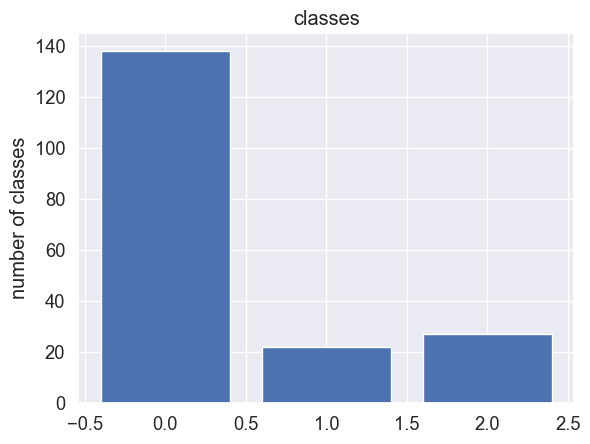

In [393]:
Y_train_categorical=np.argmax(X_data_gen_test.y_classification,axis=1)
classes, counts=np.unique(Y_train_categorical,return_counts=True) 

fig, ax = plt.subplots()
plt.bar(classes,counts)
ax.set_ylabel('number of classes')
ax.set_title('Test Dataset classes')
plt.show()

LSTM_AT


d:\Projetos_python\Time_Series_Forecast\acoes\utils.py:31: RuntimeWarning:

invalid value encountered in divide



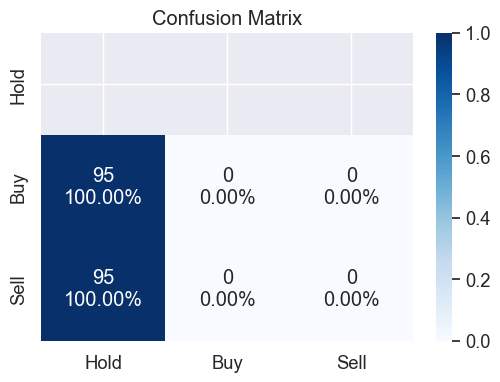

In [392]:
print('Model name:',model_name)
cf_matrix = utils.confusion_matrix(np.argmax(X_data_gen_val.y_classification[idxs],axis=1),np.argmax(label_pred,axis=1))
cf_matrix 
utils.plot_confusion_matrix(gesture_list= ['Hold','Buy','Sell'], cf_matrix=cf_matrix)

In [359]:
import utils
for model_name in trained_best_models:
    label_pred = trained_best_models[model_name].predict(test_data)
    print(model_name,' classification Accuracy',utils.accuracy_score(targets, np.argmax(label_pred,axis=1)))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  
MLP  classification Accuracy 0.7379679144385026
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
CNN_LSTM_MultiHead  classification Accuracy 0.7379679144385026
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
LSTM_AT  classification Accuracy 0.7379679144385026


In [360]:
label_pred=trained_best_models['MLP'].predict(X_data_gen_test.comput_features(X_test))
np.unique(np.argmax(label_pred,axis=1), return_counts=True)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  


(array([0], dtype=int64), array([187], dtype=int64))

In [361]:
np.argmax(trained_best_models['MLP'].predict(X_data_gen_test.comput_features(X_train)),axis=1)

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

#### Using Machine Learning models

In [362]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Define ML models and their names
ML_models = {
    'SVM': SVC(kernel='linear',decision_function_shape='ovr'),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'Logistic Regression': LogisticRegression(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'XGBoost RF': xgb.XGBRFClassifier(n_estimators=100)
}

# Iterate over ML models
for name, model in ML_models.items():
    # Train the model
    model.fit(X_data_gen_train.features, np.argmax(X_data_gen_train.y_classification, axis=1))

    # Make predictions on datasets
    train_pred = model.predict(X_data_gen_train.features)
    val_pred = model.predict(X_data_gen_val.features)
    test_pred = model.predict(X_data_gen_test.comput_features(X_test))

    # Calculate accuracy on datasets
    train_accuracy = accuracy_score(np.argmax(X_data_gen_train.y_classification, axis=1), train_pred)
    val_accuracy = accuracy_score(np.argmax(X_data_gen_val.y_classification, axis=1), val_pred)
    test_accuracy = accuracy_score(np.argmax(X_data_gen_test.comput_outputs(X_test), axis=1), test_pred)

    # Print results
    print('-------------------------------------------------------------')
    print(f'{name} - Train Classification Accuracy: {train_accuracy}')
    print(f'{name} - Validation Classification Accuracy: {val_accuracy}')
    print(f'{name} - Test Classification Accuracy: {test_accuracy}')


-------------------------------------------------------------
SVM - Train Classification Accuracy: 0.9305936073059361
SVM - Validation Classification Accuracy: 0.8064516129032258
SVM - Test Classification Accuracy: 0.7005347593582888
-------------------------------------------------------------
Decision Tree - Train Classification Accuracy: 1.0
Decision Tree - Validation Classification Accuracy: 0.33548387096774196
Decision Tree - Test Classification Accuracy: 0.17647058823529413
-------------------------------------------------------------
Random Forest - Train Classification Accuracy: 1.0
Random Forest - Validation Classification Accuracy: 0.32688172043010755
Random Forest - Test Classification Accuracy: 0.22994652406417113


d:\Projetos_python\Time_Series_Forecast\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



-------------------------------------------------------------
Logistic Regression - Train Classification Accuracy: 0.5339421613394216
Logistic Regression - Validation Classification Accuracy: 0.3247311827956989
Logistic Regression - Test Classification Accuracy: 0.31016042780748665
-------------------------------------------------------------
K-Nearest Neighbors - Train Classification Accuracy: 0.8447488584474886
K-Nearest Neighbors - Validation Classification Accuracy: 0.24731182795698925
K-Nearest Neighbors - Test Classification Accuracy: 0.21390374331550802
-------------------------------------------------------------
XGBoost RF - Train Classification Accuracy: 0.7266362252663623
XGBoost RF - Validation Classification Accuracy: 0.24731182795698925
XGBoost RF - Test Classification Accuracy: 0.12834224598930483


### Get new values to future prediction 

In [363]:
dias_antes=1
n_steps=7

print("Temos dados até o dia :",T_test.iloc[-1].date())

print("Estamos Fornecendo dados até o dia :",T_test.iloc[-1].date() -datetime.timedelta(days=dias_antes))

print("O modelo fará previsões até o dia: ",T_test.iloc[-1].date() -datetime.timedelta(days=dias_antes) + datetime.timedelta(days=n_steps))

Temos dados até o dia : 2021-07-15
Estamos Fornecendo dados até o dia : 2021-07-14
O modelo fará previsões até o dia:  2021-07-21
